In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qiskit

2023-06-10 14:59:22.075050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


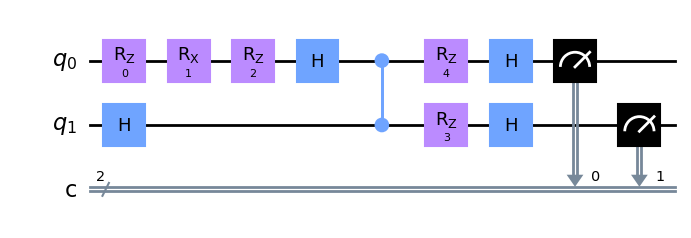

In [2]:
dev = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev)
def circuit(x):
    qml.Hadamard(wires=1)
    qml.RZ(0,wires=0)
    qml.RX(1,wires=0)
    qml.RZ(2,wires=0)
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(3,wires=1)
    qml.RZ(4,wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)   
    return qml.expval(qml.PauliZ(0))

circuit([0,1,2,3,4])

dev._circuit.draw(output='mpl')

In [3]:
dev1 = qml.device('default.mixed', wires=2)

In [4]:
def real():
    qml.Hadamard(wires=1) 

In [5]:
def generator(w,**kwargs):
    qml.RZ(w[0],wires=0)
    qml.RX(w[1],wires=0)
    qml.RZ(w[2],wires=0)
    qml.BitFlip(p,wires=0)

In [6]:
def discriminator(w,**kwargs):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0],wires=1)
    qml.RZ(w[1],wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)
    qml.BitFlip(p,wires=0)
    qml.BitFlip(p,wires=1)

In [7]:
@qml.qnode(dev1, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))

In [8]:
p='p'
print(qml.draw(real_gen_disc_circuit)([ 0,0,0],[ 0,0]))

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)──BitFlip(p)──H─╭Z──RZ(0.00)──H──BitFlip(p)─┤ ╭<𝓗>
1: ──H───────────────────────────────────────────╰●──RZ(0.00)──H──BitFlip(p)─┤ ╰<𝓗>


In [9]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [10]:
def disc_cost(disc_weights):
    cost =1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [11]:
@qml.qnode(dev1, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev1, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [19]:
p = 0.01
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))
    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

# train only generator while discriminator is a perfect swap frozen discriminator
loss_val_d = []
loss_val_g = []
#step_d = []
step_gf = []
sg_f =[]
epochs = 300
a = 1
for i in range(epochs): 
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf            

Step 0: cost = 0.24993230232493885
Step 1: cost = 0.24982526813682893
Step 2: cost = 0.24966933008519862
Step 3: cost = 0.24946454397075507
Step 4: cost = 0.24921098797898322
Step 5: cost = 0.24890876112333282
Step 6: cost = 0.24855798260689055
Step 7: cost = 0.24815879149082987
Step 8: cost = 0.24771134648664406
Step 9: cost = 0.24721582580371754
Step 10: cost = 0.24667242702254713
Step 11: cost = 0.2460813669792833
Step 12: cost = 0.24544288165409084
Step 13: cost = 0.24475722605915068
Step 14: cost = 0.2440246741238573
Step 15: cost = 0.2432455185757183
Step 16: cost = 0.24242007081602457
Step 17: cost = 0.24154866078969062
Step 18: cost = 0.24063163684887987
Step 19: cost = 0.23966936561016072
Step 20: cost = 0.23866223180503704
Step 21: cost = 0.23761063812375346
Step 22: cost = 0.2365150050523259
Step 23: cost = 0.23537577070277346
Step 24: cost = 0.23419339063655603
Step 25: cost = 0.2329683376812388
Step 26: cost = 0.2317011017404177
Step 27: cost = 0.2303921895969513
Step 28: 

Step 223: cost = 0.005005800203854327
Step 224: cost = 0.005007958180311689
Step 225: cost = 0.005005797330443262
Step 226: cost = 0.005007922700306339
Step 227: cost = 0.005005794612537584
Step 228: cost = 0.005007888182670728
Step 229: cost = 0.005005792045541579
Step 230: cost = 0.005007854588452376
Step 231: cost = 0.0050057896249877665
Step 232: cost = 0.005007821880981367
Step 233: cost = 0.005005787346533758
Step 234: cost = 0.0050077900256906005
Step 235: cost = 0.005005785205958929
Step 236: cost = 0.005007758989953426
Step 237: cost = 0.005005783199160924
Step 238: cost = 0.0050077287429377
Step 239: cost = 0.005005781322152458
Step 240: cost = 0.005007699255472536
Step 241: cost = 0.005005779571057606
Step 242: cost = 0.005007670499928646
Step 243: cost = 0.005005777942109546
Step 244: cost = 0.005007642450108735
Step 245: cost = 0.005005776431646347
Step 246: cost = 0.005007615081147998
Step 247: cost = 0.005005775036108412
Step 248: cost = 0.005007588369423138
Step 249: co

In [18]:
len(step_gf)

60

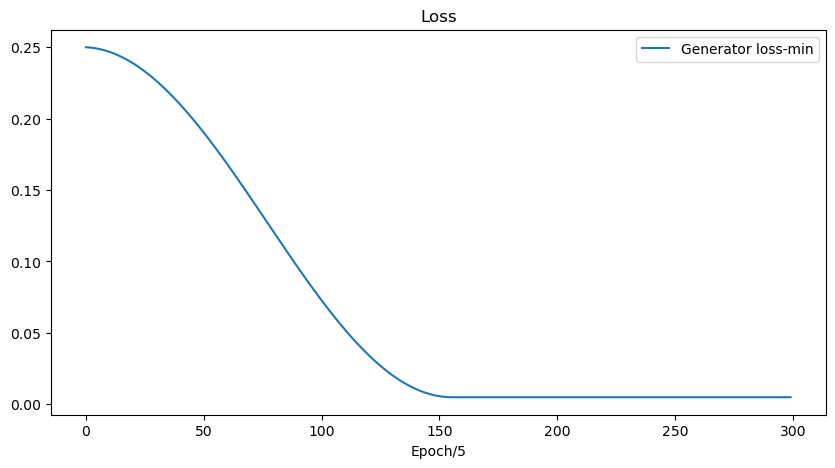

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

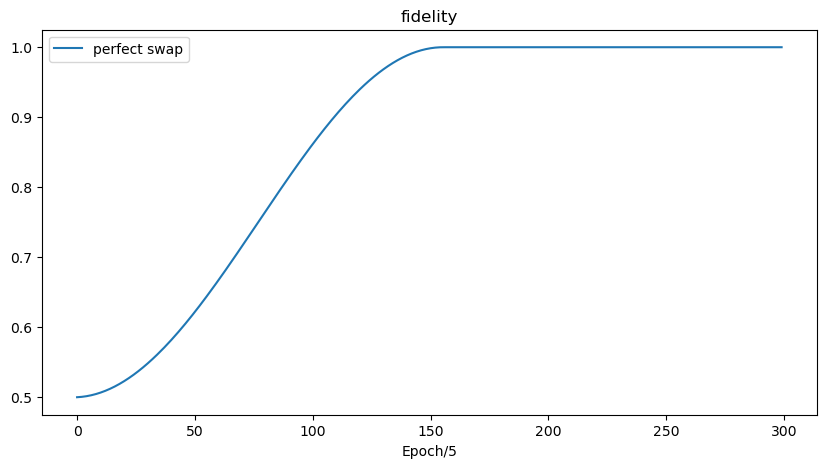

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

In [ ]:
range(len(step_g))

In [ ]:
len(perfect_swap)

In [ ]:
len(perfect_step_g)

In [22]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 150
a1 = 1
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 75
a2 = 1
a3 = 1
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.24993230232493885
Step 1: cost = 0.24982526813682893
Step 2: cost = 0.24966933008519862
Step 3: cost = 0.24946454397075507
Step 4: cost = 0.24921098797898322
Step 5: cost = 0.24890876112333282
Step 6: cost = 0.24855798260689055
Step 7: cost = 0.24815879149082987
Step 8: cost = 0.24771134648664406
Step 9: cost = 0.24721582580371754
Step 10: cost = 0.24667242702254713
Step 11: cost = 0.2460813669792833
Step 12: cost = 0.24544288165409084
Step 13: cost = 0.24475722605915068
Step 14: cost = 0.2440246741238573
Step 15: cost = 0.2432455185757183
Step 16: cost = 0.24242007081602457
Step 17: cost = 0.24154866078969062
Step 18: cost = 0.24063163684887987
Step 19: cost = 0.23966936561016072
Step 20: cost = 0.23866223180503704
Step 21: cost = 0.23761063812375346
Step 22: cost = 0.2365150050523259
Step 23: cost = 0.23537577070277346
Step 24: cost = 0.23419339063655603
Step 25: cost = 0.2329683376812388
Step 26: cost = 0.2317011017404177
Step 27: cost = 0.2303921895969513
Step 28: 

Step 225: cost = 0.006584004944108046
Step 226: cost = 0.9932241540641333
Step 227: cost = 0.006646757104670276
Step 228: cost = 0.9931570132994745
Step 229: cost = 0.006712015776299346
Step 230: cost = 0.9930939599028631
Step 231: cost = 0.006776739320731945
Step 232: cost = 0.993025856282578
Step 233: cost = 0.006845834605271273
Step 234: cost = 0.9929579432454414
Step 235: cost = 0.006912453384152417
Step 236: cost = 0.9928890950670499
Step 237: cost = 0.006985251022652655
Step 238: cost = 0.9928163227317551
Step 239: cost = 0.007053696700546841
Step 240: cost = 0.9927469291348229
Step 241: cost = 0.007130045069192709
Step 242: cost = 0.9926693224540646
Step 243: cost = 0.007200248817034127
Step 244: cost = 0.9925995808928503
Step 245: cost = 0.0072799900658833405
Step 246: cost = 0.9925171698801577
Step 247: cost = 0.007351877409012275
Step 248: cost = 0.9924472911170934
Step 249: cost = 0.007434857520779992
Step 250: cost = 0.992360088164238
Step 251: cost = 0.0075083415023010636


In [ ]:
#step_g

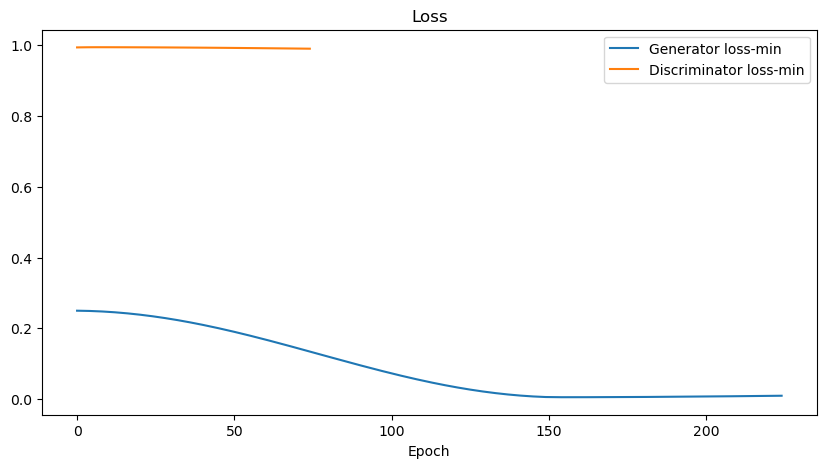

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

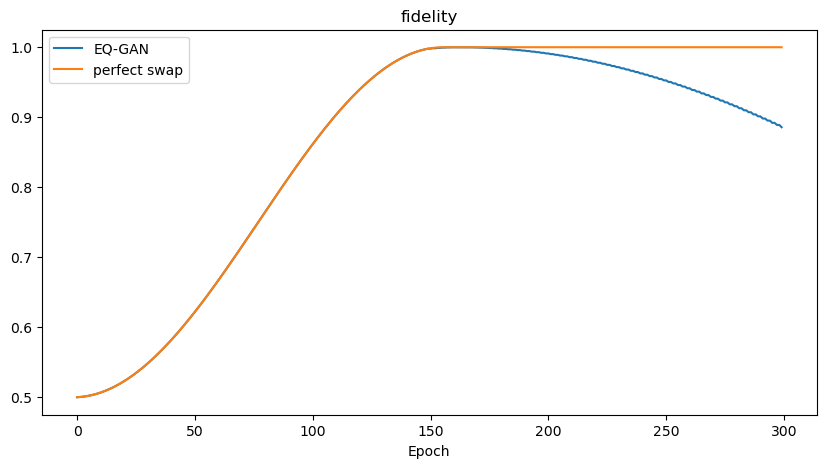

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 2
a1 = 40
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 8
a2 = 2
a3 = 2
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
p

In [ ]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 3
a1 = 50
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 15
a2 = 2
a3 = 2
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()